In [1]:
# Cell 1: Install HuggingFace Transformers, Datasets, and Torch (if not installed)
!pip install --quiet torch torchvision
!pip install --quiet transformers datasets timm
!pip install --quiet huggingface_hub --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 302.8 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [2]:
# Cell 2: Imports and Device Setup

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
from torchvision import transforms
import pandas as pd
import os

# Check device (should be CUDA on Kaggle GPU notebook)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-07-27 17:17:16.983256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753636637.190233      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753636637.251968      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [3]:
# Cell 3: List all .tif images and their labels from EuroSATallBands

import glob

# Path to EuroSATallBands (Change this if your path is different)
BANDS_PATH = "/kaggle/input/eurosatallbands-32"

class_names = sorted(os.listdir(BANDS_PATH))
data = []

for class_name in class_names:
    class_folder = os.path.join(BANDS_PATH, class_name)
    tiffs = glob.glob(os.path.join(class_folder, "*.tif"))
    for tif in tiffs:
        data.append({"image_path": tif, "label": class_name})

df = pd.DataFrame(data)
print(df.head())
print(f"Total samples: {len(df)}")
print(f"Classes: {df['label'].unique()}")

                                          image_path       label
0  /kaggle/input/eurosatallbands-32/AnnualCrop/An...  AnnualCrop
1  /kaggle/input/eurosatallbands-32/AnnualCrop/An...  AnnualCrop
2  /kaggle/input/eurosatallbands-32/AnnualCrop/An...  AnnualCrop
3  /kaggle/input/eurosatallbands-32/AnnualCrop/An...  AnnualCrop
4  /kaggle/input/eurosatallbands-32/AnnualCrop/An...  AnnualCrop
Total samples: 27597
Classes: ['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [4]:
# Cell 4: Encode labels and split dataframe

from sklearn.model_selection import train_test_split

# Create label mapping
label2id = {name: i for i, name in enumerate(sorted(df['label'].unique()))}
id2label = {v: k for k, v in label2id.items()}

df['label_id'] = df['label'].map(label2id)

# Stratified split
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label_id'])

print(f"Train: {len(df_train)}\nVal: {len(df_val)}\nTest: {len(df_test)}")
print("Label mapping:", label2id)

Train: 22077
Val: 2760
Test: 2760
Label mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [5]:
# Cell 5: Install rasterio for reading .tif images
!pip install --quiet rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.3 MB/s eta 0:00:00


In [6]:
# Cell 6 (Combined): EuroSAT prithvi-6-band Dataset definition, load test, one sample

import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np

class EuroSATPrithvi6BandDataset(Dataset):
    def __init__(self, df, label2id, transform=None):
        self.df = df.reset_index(drop=True)
        self.label2id = label2id
        self.transform = transform
        # Blue, Green, Red, Narrow NIR, SWIR1, SWIR2 = [1,2,3,8,10,11]
        self.band_indices = [1, 2, 3, 8, 10, 11]  

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        image_path = record['image_path']
        label = self.label2id[record['label']]

        with rasterio.open(image_path) as src:
            img = src.read()  # (13, H, W)
            img = img[self.band_indices, :, :]  # select only 6 needed bands
            img = img.astype(np.float32)
            img = img / img.max() if img.max() > 1 else img   # normalize to [0,1]

        if self.transform:
            img = self.transform(torch.from_numpy(img))

        return {
            "pixel_values": torch.from_numpy(img).float(),  # (6, H, W)
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Instantiate for train/val/test (transforms will be handled later if needed)
train_dataset = EuroSATPrithvi6BandDataset(df_train, label2id)
val_dataset   = EuroSATPrithvi6BandDataset(df_val, label2id)
test_dataset  = EuroSATPrithvi6BandDataset(df_test, label2id)

# Print shapes and label for a sample
sample = train_dataset[0]
print("Shape of 6-band img:", sample['pixel_values'].shape)
print("Label (numeric):", sample['labels'])

Shape of 6-band img: torch.Size([6, 32, 32])
Label (numeric): tensor(4)


In [7]:
import sys
import importlib.util
import torch
import json
import os

MODEL_DIR = "/kaggle/input/models"

# Import model code
spec = importlib.util.spec_from_file_location("prithvi_mae", os.path.join(MODEL_DIR, "prithvi_mae.py"))
prithvi_mae = importlib.util.module_from_spec(spec)
sys.modules["prithvi_mae"] = prithvi_mae
spec.loader.exec_module(prithvi_mae)

# Load config.json
with open(os.path.join(MODEL_DIR, "config.json")) as f:
    config = json.load(f)

print("Config loaded:", config['pretrained_cfg'])

# Instantiate the model using only pretrained_cfg (not the outer dict)
mae_model = prithvi_mae.PrithviMAE(**config['pretrained_cfg'])
print("Instantiated PrithviMAE.")

# Load weights
ckpt = torch.load(os.path.join(MODEL_DIR, "Prithvi_EO_V2_300M.pt"), map_location="cpu")
mae_model.load_state_dict(ckpt, strict=False)
print("Loaded pretrained weights.")

Config loaded: {'img_size': 224, 'num_frames': 4, 'patch_size': [1, 16, 16], 'in_chans': 6, 'embed_dim': 1024, 'depth': 24, 'num_heads': 16, 'decoder_embed_dim': 512, 'decoder_depth': 8, 'decoder_num_heads': 16, 'mlp_ratio': 4, 'coords_encoding': [], 'coords_scale_learn': False, 'mask_ratio': 0.75, 'norm_pix_loss': False, 'bands': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07'], 'mean': [1087.0, 1342.0, 1433.0, 2734.0, 1958.0, 1363.0], 'std': [2248.0, 2179.0, 2178.0, 1850.0, 1242.0, 1049.0], 'origin_url': 'https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M', 'paper_ids': 'arXiv:X.X'}
Instantiated PrithviMAE.
Loaded pretrained weights.


In [8]:
# Cell 8: Define a Prithvi EuroSAT classifier model

import torch.nn as nn
import torch

class PrithviEuroSATClassifier(nn.Module):
    def __init__(self, pretrained_mae, num_classes):
        super().__init__()
        self.encoder = pretrained_mae.encoder  # Use the encoder for features
        self.norm = pretrained_mae.encoder.norm  # Final norm layer after encoder
        self.cls_head = nn.Linear(self.encoder.embed_dim, num_classes)
    
    def forward(self, x):
        # The encoder expects shape [B, C, T, H, W].
        # We use T=1 (single temporal step) for EuroSAT images:
        if len(x.shape) == 4:
            # Add time dimension (T=1)
            x = x.unsqueeze(2)
        features = self.encoder(x)[0]  # [B, num_tokens+1, embed_dim], first is CLS token
        cls_tok = features[:, 0]       # CLS token ([B, embed_dim])
        logits = self.cls_head(cls_tok)
        return logits

# Instantiate your classifier
NUM_CLASSES = len(label2id)
model = PrithviEuroSATClassifier(mae_model, num_classes=NUM_CLASSES)
model = model.to(device)

print("EuroSAT classifier ready:", model)

EuroSAT classifier ready: PrithviEuroSATClassifier(
  (encoder): PrithviViT(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(6, 1024, kernel_size=(1, 16, 16), stride=(1, 16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False

In [9]:
# Cell 9: DataLoaders, Loss, Optimizer

from torch.utils.data import DataLoader

BATCH_SIZE = 512  # Adjust as Kaggle GPU memory allows, 16 or 8 is usually safe
NUM_WORKERS = 8  # You can try 4 for faster I/O if RAM allows

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

print("DataLoaders, Loss, and Optimizer created.")

DataLoaders, Loss, and Optimizer created.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
import types

def patched_forward(self, x, temporal_coords=None, location_coords=None, mask_ratio=0.75):
    if len(x.shape) == 4 and self.patch_embed.input_size[0] == 1:
        x = x.unsqueeze(2)
    sample_shape = x.shape[-3:]
    x = self.patch_embed(x)
    pos_embed = self.interpolate_pos_encoding(sample_shape)
    pos_embed = pos_embed.to(x.device)  # <--- Core fix: move pos_embed to correct device!
    x = x + pos_embed[:, 1:, :]
    if self.temporal_encoding and temporal_coords is not None:
        num_tokens_per_frame = x.shape[1] // self.num_frames
        temporal_encoding = self.temporal_embed_enc(temporal_coords, num_tokens_per_frame)
        x = x + temporal_encoding
    if self.location_encoding and location_coords is not None:
        location_encoding = self.location_embed_enc(location_coords)
        x = x + location_encoding
    x, mask, ids_restore = self.random_masking(x, mask_ratio)
    cls_token = self.cls_token + pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    for block in self.blocks:
        x = block(x)
    x = self.norm(x)
    return x, mask, ids_restore

# Patch your model's encoder:
model.encoder.forward = types.MethodType(patched_forward, model.encoder)

Epoch 1 [Train]: 100%|██████████| 44/44 [01:14<00:00,  1.70s/it]


Epoch 1 | Train Loss: 1.5763 | Train Acc: 0.4232


Epoch 1 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 1 | Val Loss: 1.2341 | Val Acc: 0.5652
Saved new best model.


Epoch 2 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 2 | Train Loss: 1.0086 | Train Acc: 0.6307


Epoch 2 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Epoch 2 | Val Loss: 1.0242 | Val Acc: 0.6344
Saved new best model.


Epoch 3 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 3 | Train Loss: 0.9110 | Train Acc: 0.6769


Epoch 3 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 3 | Val Loss: 0.8853 | Val Acc: 0.6812
Saved new best model.


Epoch 4 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 4 | Train Loss: 0.8359 | Train Acc: 0.7016


Epoch 4 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 4 | Val Loss: 0.8829 | Val Acc: 0.6761


Epoch 5 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 5 | Train Loss: 0.7808 | Train Acc: 0.7236


Epoch 5 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Epoch 5 | Val Loss: 0.8941 | Val Acc: 0.6819
Saved new best model.


Epoch 6 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 6 | Train Loss: 0.7712 | Train Acc: 0.7278


Epoch 6 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Epoch 6 | Val Loss: 0.9786 | Val Acc: 0.6638


Epoch 7 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 7 | Train Loss: 0.7406 | Train Acc: 0.7395


Epoch 7 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 7 | Val Loss: 0.7381 | Val Acc: 0.7351
Saved new best model.


Epoch 8 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.38it/s]


Epoch 8 | Train Loss: 0.6924 | Train Acc: 0.7564


Epoch 8 [Val]: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Epoch 8 | Val Loss: 0.6941 | Val Acc: 0.7493
Saved new best model.


Epoch 9 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 9 | Train Loss: 0.6674 | Train Acc: 0.7665


Epoch 9 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Epoch 9 | Val Loss: 0.6993 | Val Acc: 0.7547
Saved new best model.


Epoch 10 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 10 | Train Loss: 0.6444 | Train Acc: 0.7765


Epoch 10 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 10 | Val Loss: 0.7030 | Val Acc: 0.7587
Saved new best model.


Epoch 11 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 11 | Train Loss: 0.6179 | Train Acc: 0.7805


Epoch 11 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 11 | Val Loss: 0.6815 | Val Acc: 0.7634
Saved new best model.


Epoch 12 [Train]: 100%|██████████| 44/44 [00:34<00:00,  1.28it/s]


Epoch 12 | Train Loss: 0.6021 | Train Acc: 0.7896


Epoch 12 [Val]: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Epoch 12 | Val Loss: 0.7141 | Val Acc: 0.7533


Epoch 13 [Train]: 100%|██████████| 44/44 [00:32<00:00,  1.35it/s]


Epoch 13 | Train Loss: 0.6074 | Train Acc: 0.7865


Epoch 13 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 13 | Val Loss: 0.6664 | Val Acc: 0.7594


Epoch 14 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 14 | Train Loss: 0.5776 | Train Acc: 0.7978


Epoch 14 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 14 | Val Loss: 0.6905 | Val Acc: 0.7685
Saved new best model.


Epoch 15 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 15 | Train Loss: 0.5931 | Train Acc: 0.7912


Epoch 15 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 15 | Val Loss: 0.7266 | Val Acc: 0.7522


Epoch 16 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 16 | Train Loss: 0.5647 | Train Acc: 0.8039


Epoch 16 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 16 | Val Loss: 0.6135 | Val Acc: 0.7826
Saved new best model.


Epoch 17 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 17 | Train Loss: 0.5489 | Train Acc: 0.8088


Epoch 17 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch 17 | Val Loss: 0.6130 | Val Acc: 0.7870
Saved new best model.


Epoch 18 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch 18 | Train Loss: 0.5368 | Train Acc: 0.8125


Epoch 18 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 18 | Val Loss: 0.6155 | Val Acc: 0.7870


Epoch 19 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 19 | Train Loss: 0.5379 | Train Acc: 0.8142


Epoch 19 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Epoch 19 | Val Loss: 0.5705 | Val Acc: 0.8014
Saved new best model.


Epoch 20 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 20 | Train Loss: 0.5152 | Train Acc: 0.8220


Epoch 20 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 20 | Val Loss: 0.5880 | Val Acc: 0.7953


Epoch 21 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 21 | Train Loss: 0.5387 | Train Acc: 0.8127


Epoch 21 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 21 | Val Loss: 0.5560 | Val Acc: 0.8087
Saved new best model.


Epoch 22 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch 22 | Train Loss: 0.4941 | Train Acc: 0.8281


Epoch 22 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 22 | Val Loss: 0.6591 | Val Acc: 0.7638


Epoch 23 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 23 | Train Loss: 0.5147 | Train Acc: 0.8222


Epoch 23 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 23 | Val Loss: 0.6238 | Val Acc: 0.7895


Epoch 24 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 24 | Train Loss: 0.5185 | Train Acc: 0.8202


Epoch 24 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 24 | Val Loss: 0.5567 | Val Acc: 0.8094
Saved new best model.


Epoch 25 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 25 | Train Loss: 0.4943 | Train Acc: 0.8286


Epoch 25 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 25 | Val Loss: 0.5542 | Val Acc: 0.8076


Epoch 26 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 26 | Train Loss: 0.4741 | Train Acc: 0.8366


Epoch 26 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 26 | Val Loss: 0.6450 | Val Acc: 0.7725


Epoch 27 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 27 | Train Loss: 0.4611 | Train Acc: 0.8396


Epoch 27 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 27 | Val Loss: 0.5827 | Val Acc: 0.8091


Epoch 28 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 28 | Train Loss: 0.4710 | Train Acc: 0.8355


Epoch 28 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 28 | Val Loss: 0.6672 | Val Acc: 0.7775


Epoch 29 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 29 | Train Loss: 0.4670 | Train Acc: 0.8382


Epoch 29 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Epoch 29 | Val Loss: 0.6095 | Val Acc: 0.7982


Epoch 30 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.39it/s]


Epoch 30 | Train Loss: 0.4624 | Train Acc: 0.8381


Epoch 30 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 30 | Val Loss: 0.5261 | Val Acc: 0.8178
Saved new best model.


Epoch 31 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 31 | Train Loss: 0.4376 | Train Acc: 0.8474


Epoch 31 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 31 | Val Loss: 0.5643 | Val Acc: 0.8080


Epoch 32 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 32 | Train Loss: 0.4361 | Train Acc: 0.8475


Epoch 32 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 32 | Val Loss: 0.5651 | Val Acc: 0.8109


Epoch 33 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch 33 | Train Loss: 0.4378 | Train Acc: 0.8468


Epoch 33 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 33 | Val Loss: 0.5864 | Val Acc: 0.7975


Epoch 34 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 34 | Train Loss: 0.4342 | Train Acc: 0.8493


Epoch 34 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 34 | Val Loss: 0.5531 | Val Acc: 0.8156


Epoch 35 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 35 | Train Loss: 0.4131 | Train Acc: 0.8589


Epoch 35 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 35 | Val Loss: 0.5847 | Val Acc: 0.7989


Epoch 36 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 36 | Train Loss: 0.4268 | Train Acc: 0.8525


Epoch 36 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 36 | Val Loss: 0.5755 | Val Acc: 0.7949


Epoch 37 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 37 | Train Loss: 0.4054 | Train Acc: 0.8597


Epoch 37 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 37 | Val Loss: 0.5402 | Val Acc: 0.8261
Saved new best model.


Epoch 38 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch 38 | Train Loss: 0.4154 | Train Acc: 0.8548


Epoch 38 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 38 | Val Loss: 0.5426 | Val Acc: 0.8178


Epoch 39 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 39 | Train Loss: 0.4212 | Train Acc: 0.8517


Epoch 39 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 39 | Val Loss: 0.5294 | Val Acc: 0.8134


Epoch 40 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 40 | Train Loss: 0.4139 | Train Acc: 0.8575


Epoch 40 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 40 | Val Loss: 0.5175 | Val Acc: 0.8203


Epoch 41 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


Epoch 41 | Train Loss: 0.4016 | Train Acc: 0.8597


Epoch 41 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Epoch 41 | Val Loss: 0.5407 | Val Acc: 0.8167


Epoch 42 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 42 | Train Loss: 0.3840 | Train Acc: 0.8690


Epoch 42 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 42 | Val Loss: 0.5418 | Val Acc: 0.8159


Epoch 43 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 43 | Train Loss: 0.3667 | Train Acc: 0.8723


Epoch 43 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 43 | Val Loss: 0.5664 | Val Acc: 0.8029


Epoch 44 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 44 | Train Loss: 0.3680 | Train Acc: 0.8729


Epoch 44 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 44 | Val Loss: 0.5715 | Val Acc: 0.8091


Epoch 45 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 45 | Train Loss: 0.3696 | Train Acc: 0.8734


Epoch 45 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 45 | Val Loss: 0.5405 | Val Acc: 0.8207


Epoch 46 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 46 | Train Loss: 0.3588 | Train Acc: 0.8747


Epoch 46 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 46 | Val Loss: 0.5156 | Val Acc: 0.8257


Epoch 47 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 47 | Train Loss: 0.3510 | Train Acc: 0.8800


Epoch 47 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 47 | Val Loss: 0.6370 | Val Acc: 0.7917


Epoch 48 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 48 | Train Loss: 0.3623 | Train Acc: 0.8747


Epoch 48 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch 48 | Val Loss: 0.5526 | Val Acc: 0.8236


Epoch 49 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch 49 | Train Loss: 0.3640 | Train Acc: 0.8742


Epoch 49 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 49 | Val Loss: 0.5658 | Val Acc: 0.8159


Epoch 50 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 50 | Train Loss: 0.3406 | Train Acc: 0.8820


Epoch 50 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 50 | Val Loss: 0.5435 | Val Acc: 0.8203


Epoch 51 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 51 | Train Loss: 0.3704 | Train Acc: 0.8702


Epoch 51 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 51 | Val Loss: 0.5905 | Val Acc: 0.8109


Epoch 52 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 52 | Train Loss: 0.3352 | Train Acc: 0.8830


Epoch 52 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 52 | Val Loss: 0.5288 | Val Acc: 0.8377
Saved new best model.


Epoch 53 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 53 | Train Loss: 0.3331 | Train Acc: 0.8848


Epoch 53 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 53 | Val Loss: 0.5980 | Val Acc: 0.8138


Epoch 54 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 54 | Train Loss: 0.3324 | Train Acc: 0.8846


Epoch 54 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 54 | Val Loss: 0.5158 | Val Acc: 0.8348


Epoch 55 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


Epoch 55 | Train Loss: 0.3254 | Train Acc: 0.8877


Epoch 55 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Epoch 55 | Val Loss: 0.5405 | Val Acc: 0.8261


Epoch 56 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 56 | Train Loss: 0.3200 | Train Acc: 0.8875


Epoch 56 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Epoch 56 | Val Loss: 0.5676 | Val Acc: 0.8120


Epoch 57 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 57 | Train Loss: 0.3152 | Train Acc: 0.8894


Epoch 57 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 57 | Val Loss: 0.5775 | Val Acc: 0.8087


Epoch 58 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 58 | Train Loss: 0.3139 | Train Acc: 0.8915


Epoch 58 [Val]: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Epoch 58 | Val Loss: 0.5061 | Val Acc: 0.8384
Saved new best model.


Epoch 59 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch 59 | Train Loss: 0.3048 | Train Acc: 0.8941


Epoch 59 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 59 | Val Loss: 0.5166 | Val Acc: 0.8322


Epoch 60 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 60 | Train Loss: 0.2967 | Train Acc: 0.8960


Epoch 60 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 60 | Val Loss: 0.5528 | Val Acc: 0.8304


Epoch 61 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 61 | Train Loss: 0.3032 | Train Acc: 0.8944


Epoch 61 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Epoch 61 | Val Loss: 0.5915 | Val Acc: 0.8167


Epoch 62 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 62 | Train Loss: 0.2930 | Train Acc: 0.8997


Epoch 62 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 62 | Val Loss: 0.6990 | Val Acc: 0.7895


Epoch 63 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 63 | Train Loss: 0.3454 | Train Acc: 0.8797


Epoch 63 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 63 | Val Loss: 0.5090 | Val Acc: 0.8395
Saved new best model.


Epoch 64 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 64 | Train Loss: 0.2880 | Train Acc: 0.9007


Epoch 64 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 64 | Val Loss: 0.5103 | Val Acc: 0.8344


Epoch 65 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 65 | Train Loss: 0.2794 | Train Acc: 0.9030


Epoch 65 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Epoch 65 | Val Loss: 0.6158 | Val Acc: 0.8134


Epoch 66 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 66 | Train Loss: 0.2786 | Train Acc: 0.9033


Epoch 66 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Epoch 66 | Val Loss: 0.5443 | Val Acc: 0.8293


Epoch 67 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 67 | Train Loss: 0.2800 | Train Acc: 0.8990


Epoch 67 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Epoch 67 | Val Loss: 0.5240 | Val Acc: 0.8373


Epoch 68 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


Epoch 68 | Train Loss: 0.2678 | Train Acc: 0.9071


Epoch 68 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 68 | Val Loss: 0.5767 | Val Acc: 0.8199


Epoch 69 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 69 | Train Loss: 0.2777 | Train Acc: 0.9033


Epoch 69 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 69 | Val Loss: 0.6046 | Val Acc: 0.8152


Epoch 70 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.51it/s]


Epoch 70 | Train Loss: 0.2659 | Train Acc: 0.9070


Epoch 70 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 70 | Val Loss: 0.6398 | Val Acc: 0.8091


Epoch 71 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 71 | Train Loss: 0.2775 | Train Acc: 0.9026


Epoch 71 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 71 | Val Loss: 0.5461 | Val Acc: 0.8341


Epoch 72 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 72 | Train Loss: 0.2284 | Train Acc: 0.9214


Epoch 72 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 72 | Val Loss: 0.5936 | Val Acc: 0.8185


Epoch 73 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 73 | Train Loss: 0.2511 | Train Acc: 0.9129


Epoch 73 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 73 | Val Loss: 0.7740 | Val Acc: 0.7866


Epoch 74 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 74 | Train Loss: 0.2690 | Train Acc: 0.9076


Epoch 74 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 74 | Val Loss: 0.6804 | Val Acc: 0.8123


Epoch 75 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 75 | Train Loss: 0.2804 | Train Acc: 0.9019


Epoch 75 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 75 | Val Loss: 0.5850 | Val Acc: 0.8149


Epoch 76 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.39it/s]


Epoch 76 | Train Loss: 0.2559 | Train Acc: 0.9108


Epoch 76 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 76 | Val Loss: 0.5273 | Val Acc: 0.8290


Epoch 77 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 77 | Train Loss: 0.2621 | Train Acc: 0.9091


Epoch 77 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 77 | Val Loss: 0.5935 | Val Acc: 0.8221


Epoch 78 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 78 | Train Loss: 0.2428 | Train Acc: 0.9163


Epoch 78 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 78 | Val Loss: 0.6350 | Val Acc: 0.8091


Epoch 79 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


Epoch 79 | Train Loss: 0.2329 | Train Acc: 0.9193


Epoch 79 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 79 | Val Loss: 0.6440 | Val Acc: 0.8159


Epoch 80 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 80 | Train Loss: 0.2277 | Train Acc: 0.9210


Epoch 80 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 80 | Val Loss: 0.5713 | Val Acc: 0.8362


Epoch 81 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 81 | Train Loss: 0.2285 | Train Acc: 0.9206


Epoch 81 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


Epoch 81 | Val Loss: 0.6020 | Val Acc: 0.8181


Epoch 82 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


Epoch 82 | Train Loss: 0.2204 | Train Acc: 0.9229


Epoch 82 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 82 | Val Loss: 0.6006 | Val Acc: 0.8366


Epoch 83 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 83 | Train Loss: 0.2056 | Train Acc: 0.9277


Epoch 83 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 83 | Val Loss: 0.6105 | Val Acc: 0.8312


Epoch 84 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 84 | Train Loss: 0.2378 | Train Acc: 0.9182


Epoch 84 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


Epoch 84 | Val Loss: 0.6245 | Val Acc: 0.8243


Epoch 85 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 85 | Train Loss: 0.2085 | Train Acc: 0.9287


Epoch 85 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch 85 | Val Loss: 0.5653 | Val Acc: 0.8330


Epoch 86 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 86 | Train Loss: 0.2210 | Train Acc: 0.9205


Epoch 86 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 86 | Val Loss: 0.6349 | Val Acc: 0.8264


Epoch 87 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


Epoch 87 | Train Loss: 0.2415 | Train Acc: 0.9175


Epoch 87 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


Epoch 87 | Val Loss: 0.5830 | Val Acc: 0.8261


Epoch 88 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 88 | Train Loss: 0.2044 | Train Acc: 0.9289


Epoch 88 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 88 | Val Loss: 0.6016 | Val Acc: 0.8297


Epoch 89 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 89 | Train Loss: 0.2082 | Train Acc: 0.9268


Epoch 89 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


Epoch 89 | Val Loss: 0.6133 | Val Acc: 0.8246


Epoch 90 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 90 | Train Loss: 0.1970 | Train Acc: 0.9312


Epoch 90 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 90 | Val Loss: 0.6373 | Val Acc: 0.8239


Epoch 91 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 91 | Train Loss: 0.2137 | Train Acc: 0.9259


Epoch 91 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 91 | Val Loss: 0.5791 | Val Acc: 0.8188


Epoch 92 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 92 | Train Loss: 0.1939 | Train Acc: 0.9318


Epoch 92 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 92 | Val Loss: 0.6456 | Val Acc: 0.8275


Epoch 93 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 93 | Train Loss: 0.2065 | Train Acc: 0.9283


Epoch 93 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 93 | Val Loss: 0.6748 | Val Acc: 0.8109


Epoch 94 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 94 | Train Loss: 0.2021 | Train Acc: 0.9296


Epoch 94 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 94 | Val Loss: 0.6163 | Val Acc: 0.8359


Epoch 95 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch 95 | Train Loss: 0.1772 | Train Acc: 0.9386


Epoch 95 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 95 | Val Loss: 0.6801 | Val Acc: 0.8207


Epoch 96 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 96 | Train Loss: 0.2021 | Train Acc: 0.9302


Epoch 96 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 96 | Val Loss: 0.6341 | Val Acc: 0.8312


Epoch 97 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 97 | Train Loss: 0.1872 | Train Acc: 0.9370


Epoch 97 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 97 | Val Loss: 0.5966 | Val Acc: 0.8391


Epoch 98 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 98 | Train Loss: 0.1703 | Train Acc: 0.9407


Epoch 98 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 98 | Val Loss: 0.6354 | Val Acc: 0.8214


Epoch 99 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 99 | Train Loss: 0.1797 | Train Acc: 0.9373


Epoch 99 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Epoch 99 | Val Loss: 0.6644 | Val Acc: 0.8105


Epoch 100 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 100 | Train Loss: 0.1717 | Train Acc: 0.9403


Epoch 100 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 100 | Val Loss: 0.6389 | Val Acc: 0.8344
Training complete!


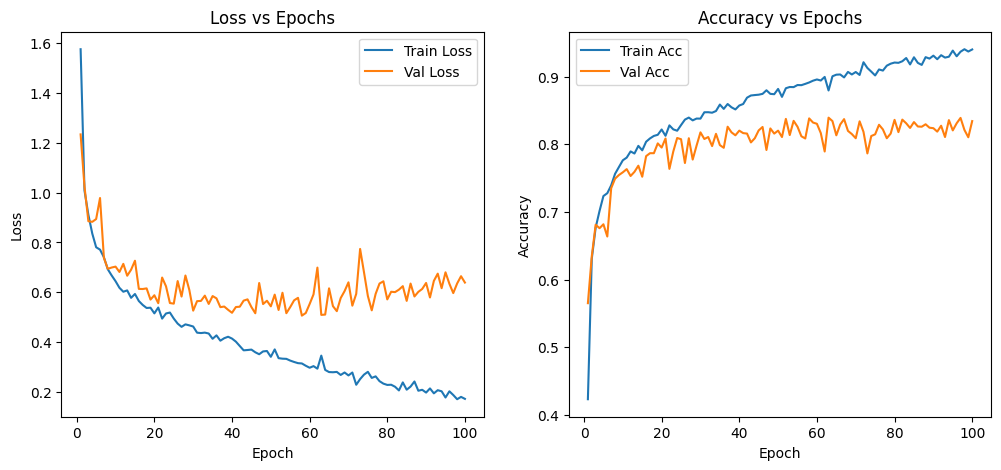

In [11]:
# Cell 10: Training/validation loop with metrics tracking and learning curves plot

from tqdm import tqdm
import matplotlib.pyplot as plt

NUM_EPOCHS = 100  # Set this >1 for meaningful curves!
best_val_acc = 0.0

# Store history
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(NUM_EPOCHS):
    # --- Training ---
    model.train()
    train_loss, correct, total = 0., 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * pixel_values.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += pixel_values.size(0)
    avg_train_loss = train_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0., 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            val_loss += loss.item() * pixel_values.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += pixel_values.size(0)
    avg_val_loss = val_loss / total
    val_acc = correct / total
    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save history
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    # Save best model (optional)
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "best_prithvi_eurosat.pt")
        best_val_acc = val_acc
        print("Saved new best model.")

print("Training complete!")

# Plot learning curves!
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

In [12]:
# Cell 11: Evaluate on the test set

from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Load the best model checkpoint (saved during validation)
model.load_state_dict(torch.load("best_prithvi_eurosat.pt"))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        logits = model(pixel_values)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += pixel_values.size(0)
test_acc = correct / total
print("Test accuracy:", test_acc)

Test: 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]

Test accuracy: 0.8365942028985507


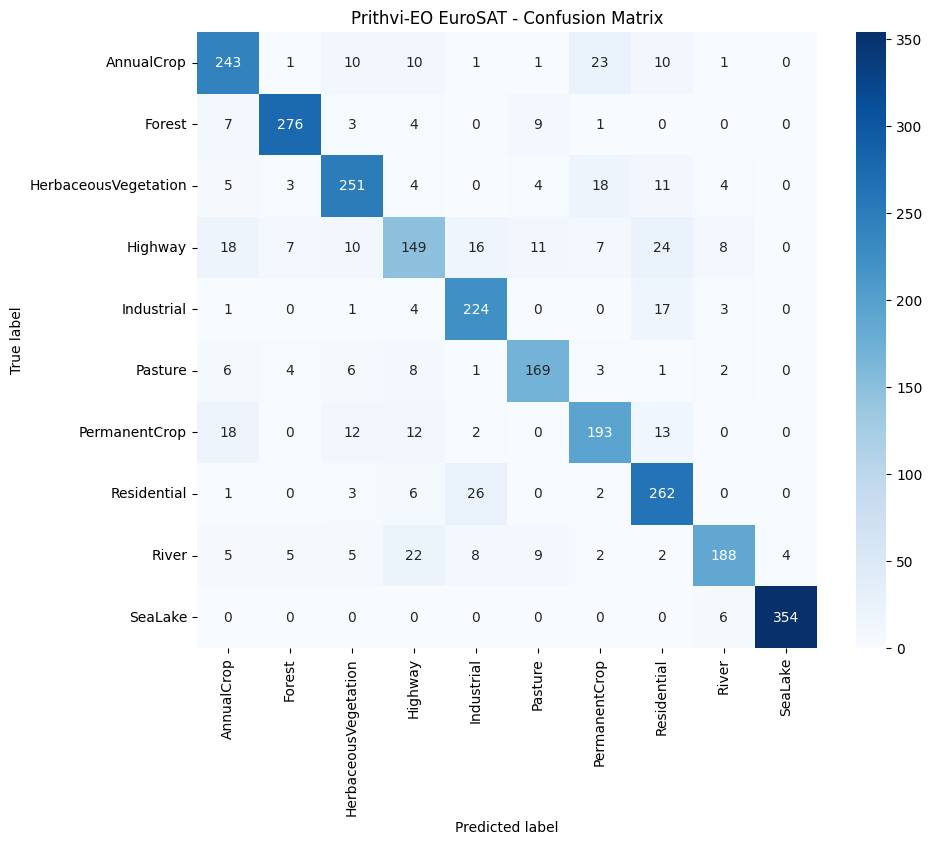

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=list(label2id.keys()), 
            yticklabels=list(label2id.keys()), cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Prithvi-EO EuroSAT - Confusion Matrix")
plt.show()

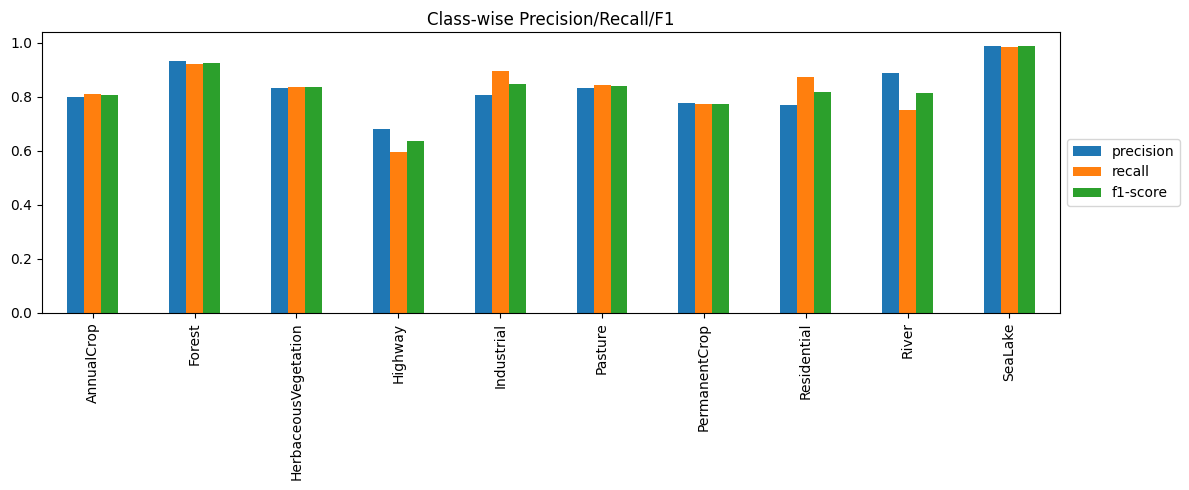

In [14]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(all_labels, all_preds, target_names=list(label2id.keys()), output_dict=True)
df_report = pd.DataFrame(report).T

ax = df_report.iloc[:-3][['precision', 'recall', 'f1-score']].plot(
    kind='bar', figsize=(12,5)
)
plt.title("Class-wise Precision/Recall/F1")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

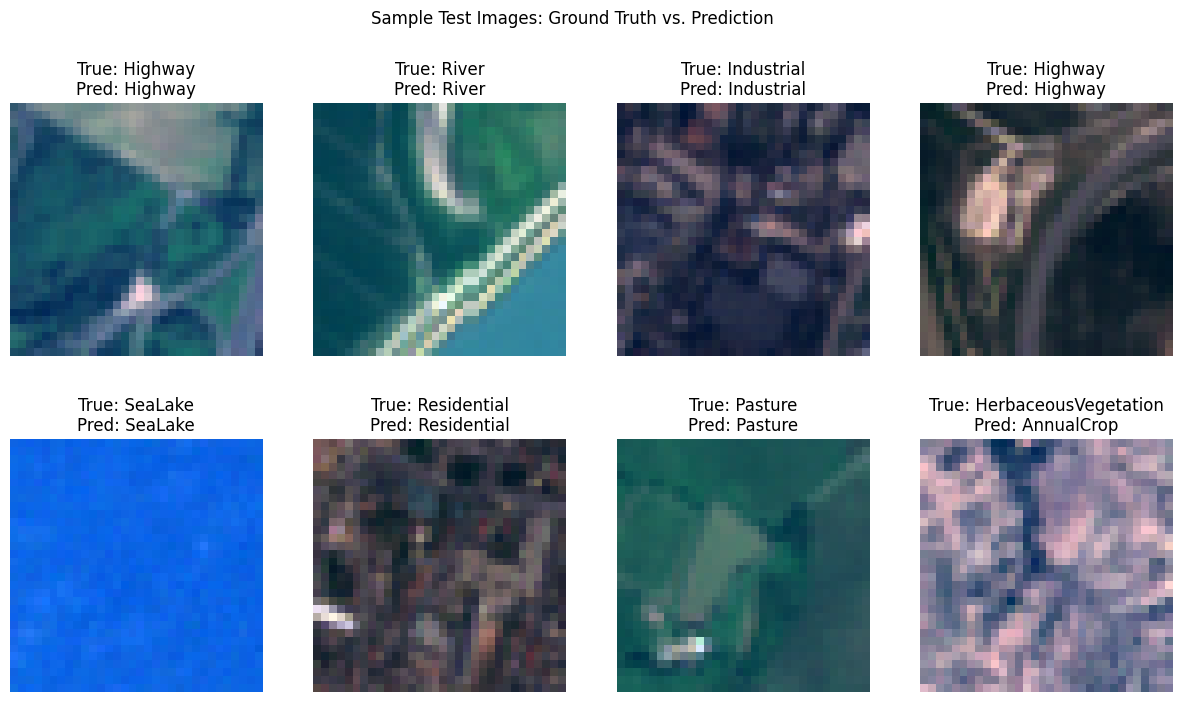

In [15]:
import random
import rasterio

idxs = random.sample(range(len(test_dataset)), 8)
plt.figure(figsize=(15,8))
for i, idx in enumerate(idxs):
    sample = test_dataset[idx]
    img = sample['pixel_values'].numpy()  # (6, 64, 64)
    # Convert to RGB for display (bands 2,3,4 ≈ G,R,B for Sentinel-2 convention)
    img_disp = img[[2,1,0],:,:]  # This may differ if your bands are ordered differently
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())  # Normalize to 0..1
    img_disp = np.transpose(img_disp, (1,2,0))
    pred = model(sample['pixel_values'].unsqueeze(0).to(device)).argmax(dim=1).item()
    plt.subplot(2,4,i+1)
    plt.imshow(img_disp)
    plt.title(f"True: {id2label[sample['labels'].item()]}\nPred: {id2label[pred]}")
    plt.axis('off')
plt.suptitle("Sample Test Images: Ground Truth vs. Prediction")
plt.show()

In [16]:
from IPython.display import FileLink

# First, ensure the file is saved in your working directory.
MODEL_FILENAME = "best_prithvi_eurosat.pt"

# Create a downloadable link
display(FileLink(MODEL_FILENAME))

/kaggle/working/best_prithvi_eurosat.pt